In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from functions import(
    identify_normality,
    z_trim_cap_outliers,
    identify_skewed_columns,
    trim_cap_skewed_outliers
)

from wrangle import binned_Inc_to_num, geography_split

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge, LassoCV

### ingest

In [3]:
# Split the data
def split_data():
    # Import the dataset
    df = pd.read_csv("dataset/cancer_reg.csv",
                 encoding='unicode_escape')

    # Train test split
    train, test= train_test_split(df, test_size=0.2, random_state=42)

    return train, test

In [4]:
# split the dataset
train, test = split_data()
train.shape, test.shape

((2437, 34), (610, 34))

In [5]:
# Performing outlier capping
def train_outlier_capping(df):
    df = df.copy()
    # Identify features that are normally and not normally distributed in the train data
    normal_features, non_normal_features = identify_normality(df)

    # Cap the outliers in the train data
    train = z_trim_cap_outliers(df, normal_features, method='cap')
    print(f"These normal features will be capped {normal_features}")

    # Of all teh non normal features, identify the extremely skewed ones with threshold as 1
    skew_feats, _ = identify_skewed_columns(df, non_normal_features, skew_threshold=1)
    print(f"These skewed columns will be capped: {skew_feats}")

    # Cap the outliers
    df = trim_cap_skewed_outliers(df, skew_feats, method="cap")

    return df

In [6]:
# perform outlier capping and store it in a different
train_cap = train_outlier_capping(train)
train_cap.shape

These normal features will be capped ['PctPublicCoverage']
These skewed columns will be capped: ['avgAnnCount', 'avgDeathsPerYear', 'incidenceRate', 'medIncome', 'popEst2015', 'studyPerCap', 'MedianAge', 'AvgHouseholdSize', 'PctBachDeg18_24', 'PctBachDeg25_Over', 'PctWhite', 'PctBlack', 'PctAsian', 'PctOtherRace', 'BirthRate']


(2437, 34)

We stored our capped train data in a different variable to test the difference between training with the capped data vs the normal data

In [7]:
# Perform some categorical wrangling
def wrangle(df):

    # binned_inc column
    df = binned_Inc_to_num(df)

    # Split the geography column
    df = geography_split(df)
    
    return df

In [8]:
# Wrangle th train data, capped_train and test data
train = wrangle(train)
train_cap = wrangle(train_cap)
test = wrangle(test)
train.shape, test.shape, train_cap.shape

((2437, 35), (610, 35), (2437, 35))

We will be training on the training set as is and we'll compare it with training with the capped data

In [9]:
train.dtypes.value_counts()

float64    29
int64       4
object      2
Name: count, dtype: int64

split into feature and label

In [10]:
# Split into feature and label
def feat_label_split(df):
    target = "TARGET_deathRate"

    feature = df.drop(columns=[target])
    label = df[target]
    
    return feature, label

In [11]:
# split original trained tata
X_train, y_train = feat_label_split(train)
# split capped data
X_train_cap, y_train_cap = feat_label_split(train_cap)
# split test data
X_test, y_test = feat_label_split(test)

In [12]:
# Verify their shape
X_train.shape, X_test.shape, X_train_cap.shape

((2437, 34), (610, 34), (2437, 34))

In [13]:
y_train.shape, y_test.shape, y_train_cap.shape

((2437,), (610,), (2437,))

### Preprocessing

Perform standard scaling on the numeric columns, simple imputer with mean    
perform one hot encoding on the categoricals

In [14]:
# log_transformer = FunctionTransformer(np.log1p, validate=False, feature_names_out = 'one-to-one')
# sqrt_transformer = FunctionTransformer(np.sqrt, validate=False, feature_names_out = 'one-to-one')

In [15]:
num_pipeline = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    # ('log', sqrt_transformer),
    ('scaler', StandardScaler())
])

In [16]:
cat_pipeline = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown="ignore"))
])

In [17]:
# Get the names of the numeric and categorical columns
num_cols = X_train.select_dtypes(include=('number')).columns
cat_cols = X_train.select_dtypes(include=('object')).columns
num_cols.shape, cat_cols.shape

((32,), (2,))

In [18]:
assert len(num_cols) + len(cat_cols) == len(X_train.columns), "Check again"

In [19]:
# Preprocessing pipeline
preprocessing = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
], sparse_threshold=0)

In [20]:
# Test the preprocessing pipeline on the train data
prep = preprocessing.fit_transform(X_train)
prep.shape

(2437, 1615)

We're at 1615 columns

### Baseline

The baseline is typically a model that makes naive predictions.

The most basic baseline is the mean

In [83]:
# Get the mean of the training data and use it as the default prediction
baseline_preds = [y_train.mean()] * len(y_train)
baseline_preds[:5]

[178.6085350841198,
 178.6085350841198,
 178.6085350841198,
 178.6085350841198,
 178.6085350841198]

In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# error metrics for linear regression
def error_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    print(f"mae: {mae}")
    print(f"rmse: {rmse}")
    print(f"R2 score {rmse}")

In [86]:
# Get teh error metrics, y_train vs baseline_preds
error_metrics(y_true=y_train, y_pred=baseline_preds)

mae: 21.098923601049272
rmse: 27.527721115623663
R2 score 27.527721115623663


mae - on average, we are off by about 21 people out of every 100_000 people in the population.

This is the baselien we need to beat to justify any model

### Modelling

Train a Lasso model on the normal data. No outlier detection and capping was performed on the normal data

In [21]:
# create a pipeline. combine the preprocessing steps and the training step
lasso_pipe = make_pipeline(
    preprocessing,
    Lasso()
)

In [22]:
# fit on X_train and y_train
lasso_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['county', 'state'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['a...
       'PercentMarried', 'PctNoHS18_24', 'PctHS18_24', 'PctSomeCol18_24',
       'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over',
       'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage',
       'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage',
       'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian',
       'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate'],
      dtype='object'))])),
                ('lasso', Lasso())])

In [23]:
# Get the preditions
y_train_pred = lasso_pipe.predict(X_train)

Next access the normality of the model. 

The residuals should be normally distributed.  
If the errors are not normally distributed then we can conclude that the model has not successfully captured all teh patterns in the data

In [24]:
from functions import assess_normality

Shapiro-Wilk Test p-value: 5.483713323380969e-15
Kolmogorov-Smirnov Test p-value: 0.0
Jarque-Bera Test p-value: 4.4258710098253086e-61


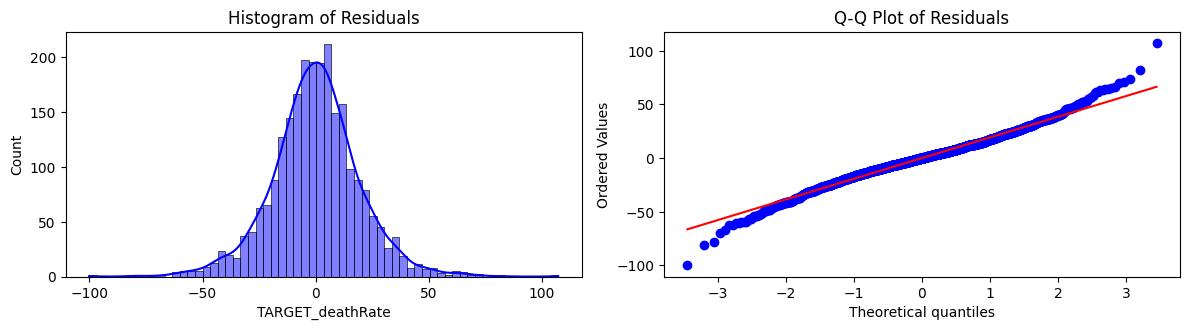

In [25]:
assess_normality(y_train, y_train_pred)

Note; Lasso regression performs feature selection by default. 

The data is fairly normal. The Lasso model seems to have captured all the information in the selected features


Additionaly. The multicolinearity assumption is satisfied since we used a Lasso model that performs feature selection

In [26]:
from functions import plot_residuals_vs_fitted

Let's test the Homoscedasticity assumption, 

Homoskedaciticity means same_variance. 
We expect teh error term to be the same across different values of the independent variables.
There should be no discernable pattern

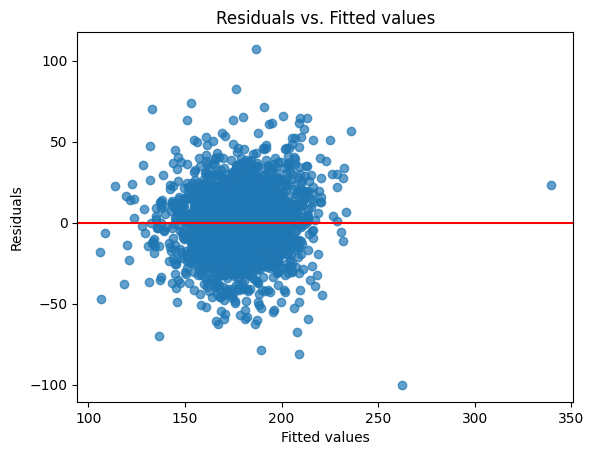

In [27]:
plot_residuals_vs_fitted(y_train, y_train_pred)

The values seem to be clustered at a point. 
Plus the data seems to be influenced by outliers as shown above

In [30]:
error_metrics(y_train, y_train_pred)

mae: 14.547902473365882
rmse: 19.406355450047734
R2 score 19.406355450047734


The absolute error is 14, teh squared error is 19. 
I think the squared error matters more in this context. We need to penalize very large errors

The R2 score 1s 19 meaning that the selected features only account for 19% of the variation in the dependent variable.
However it is important to note that R2 tends to increase with each additional feature
and adding additional features might be detrimental as each addition might make our model less useful in predicting data it has not seen before

In [31]:
from functions import mini_describe

In [32]:
# Get a description of the target varible
mini_describe(train, "TARGET_deathRate")

,count,mean,std,min,25%,50%,75%,max,Range,IQR
TARGET_deathRate,2437.0,178.608535,27.533371,59.7,161.7,178.6,195.1,362.8,303.1,33.4


the minimum death rate is 59.7% and our square error is 19. 
Our model seems to do well

In [33]:
# Get the coefficient and intercept
coefficients = lasso_pipe.named_steps["lasso"].coef_
intercept = lasso_pipe.named_steps['lasso'].intercept_

In [34]:
# Get teh feature name
feature_names = lasso_pipe.named_steps['columntransformer'].get_feature_names_out()

In [42]:
# Feature importances
feature_importances = pd.Series(coefficients, index=feature_names).sort_values(key=abs)
feature_importances.tail(14)

cat__county_Gordon County      -0.000000
num__povertyPercent             0.344843
num__BirthRate                 -0.640734
num__PctPublicCoverageAlone     0.715305
num__PctUnemployed16_Over       0.995735
num__MedianAgeMale             -1.274403
num__PctOtherRace              -1.739526
num__PctMarriedHouseholds      -1.902289
num__PctHS25_Over               1.905876
num__PctHS18_24                 2.109726
num__PctPrivateCoverage        -2.191326
num__binnedInc                 -2.428205
num__PctBachDeg25_Over         -6.171990
num__incidenceRate             10.351611
dtype: float64

Only 13 features are declared important by the model

In [45]:
# List out the most important features. by absolute values
imps = list(feature_importances.tail(13).keys())
imps

['num__povertyPercent',
 'num__BirthRate',
 'num__PctPublicCoverageAlone',
 'num__PctUnemployed16_Over',
 'num__MedianAgeMale',
 'num__PctOtherRace',
 'num__PctMarriedHouseholds',
 'num__PctHS25_Over',
 'num__PctHS18_24',
 'num__PctPrivateCoverage',
 'num__binnedInc',
 'num__PctBachDeg25_Over',
 'num__incidenceRate']

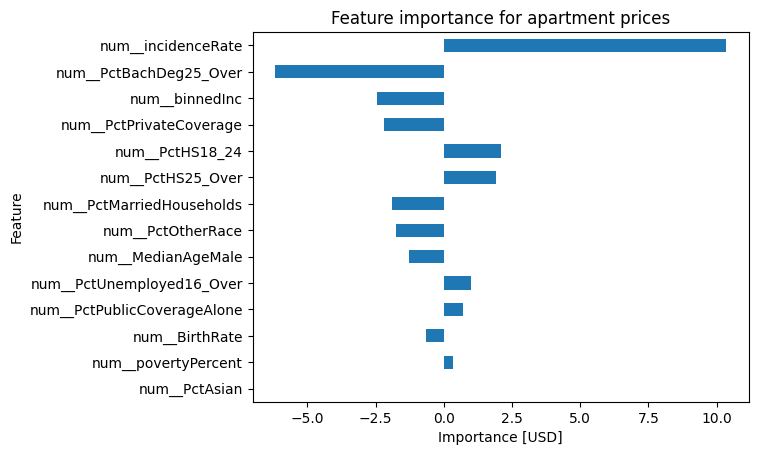

In [46]:
# Plot the feature importances
feature_importances.sort_values(key=abs).tail(14).plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature importance for cancer death rate");

'num__povertyPercent' ---- Percent of populace in poverty (2013 Census Estimates)
 'num__BirthRate' --- Number of live births relative to the number of women in the county (2013 Census Estimates)
 'num__PctPublicCoverageAlone' --- Percent of county residents with government-provided health coverage alone (2013 Census Estimates)
 'num__PctUnemployed16_Over' --- Percent of county residents ages 16 and over unemployed (2013 Census Estimates)
 'num__MedianAgeMale' --- Median age of male county residents (2013 Census Estimates) 
 'num__PctOtherRace' --- Percent of county residents who identify in a category which is not White, Black, or Asian (2013 Census Estimates
 'num__PctMarriedHouseholds' ---
 'num__PctHS25_Over' --- Percent of county residents ages 25 and over highest education attained: high school diploma (2013 Census Estimates)
 'num__PctHS18_24' --- Percent of county residents ages 18-24 highest education attained: high school diploma (2013 Census Estimates)
 'num__PctPrivateCoverage' --- Percent of county residents with private health coverage (2013 Census Estimates) 
 'num__binnedInc' --- Median income per capita binned by decile (2013 Census Estimates)
 'num__PctBachDeg25_Over' --- Percent of county residents ages 25 and over highest education attained: bachelor's degree (2013 Census Estimates)
 'num__incidenceRate'  --- Mean per capita (100,000) cancer diagnoses (years 2010-2016) 

Some of the features make sense e.g 
+ poverty percent, binned inc, pctunemployed  = All featurs affect finance.  poor peeople do not have funds to know whether they have cancer early. plus do not have fundint to treat it
+ incidence rate. The more people are diagnosed with cancer, teh more people die of cancer
+ pct public coverage, pct private coverage. These make sense, if you are covered medically then you can get treated for cancer

im baffled by some of the features e.g 
+ pct bachdeg25 over - does having a degree affect likelihood for cancer, the model says yes
+ PctHS18_24, PctHS25_Over i.e percentage of residents btw 18-24 -- the question is does age determine likelihood of cancer?
+ pct married households  --- does marriage have effect on likelihood of cancer???
+ pct other race --- If this is not true then teh model might be biased towards race.
+ birth rate --- ??????????????

### Modelling cap

Train on the capped data

In [48]:
# pipeline
lasso_pipe_cap = make_pipeline(
    preprocessing,
    Lasso()
)

In [49]:
# fit  the model
lasso_pipe_cap.fit(X_train_cap, y_train_cap)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['county', 'state'], dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['a...
       'PercentMarried', 'PctNoHS18_24', 'PctHS18_24', 'PctSomeCol18_24',
       'PctBachDeg18_24', 'PctHS25_Over', 'PctBachDeg25_Over',
       'PctEmployed16_Over', 'PctUnemployed16_Over', 'PctPrivateCoverage',
       'PctPrivateCoverageAlone', 'PctEmpPrivCoverage', 'PctPublicCoverage',
       'PctPublicCoverageAlone', 'PctWhite', 'PctBlack', 'PctAsian',
       'PctOtherRace', 'PctMarriedHouseholds', 'BirthRate'],
      dtype='object'))])),
                ('lasso', Lasso())])

In [51]:
# Get prediction on the training data
y_train_cap_pred = lasso_pipe.predict(X_train_cap)

assess the normality of the residuals

Shapiro-Wilk Test p-value: 8.191005468934872e-18
Kolmogorov-Smirnov Test p-value: 0.0
Jarque-Bera Test p-value: 1.806703929696425e-132


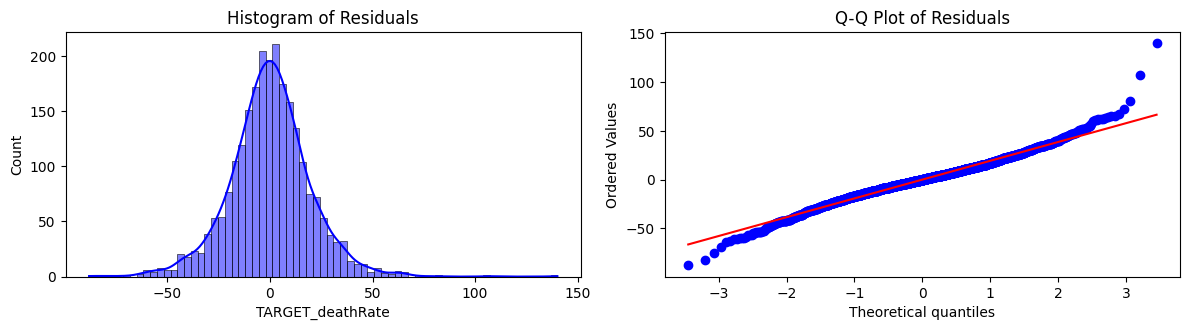

<Figure size 640x480 with 0 Axes>

In [74]:
assess_normality(y_train, y_train_cap_pred)
plt.savefig('images/normality.png')

observation. It is fairly normal althouth there are some otulers to the right.
The model might not be really  capturing  all info in the data

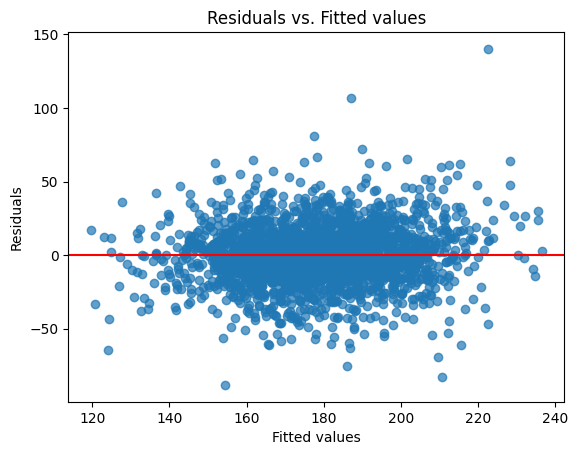

<Figure size 640x480 with 0 Axes>

In [75]:
# residuals vs fitted vaue
plot_residuals_vs_fitted(y_train, y_train_cap_pred)
plt.savefig('images/resVsFitted.jpg')

The residuals here seem to be more random. seems the capping was effective

In [54]:
error_metrics(y_train, y_train_cap_pred)

mae: 14.519165815268657
rmse: 19.498831109058216
R2 score 19.498831109058216


The error here is similar to the one from the normal data but we have more confidence in this one

There's not much difference between capped daa

In [59]:
# Get the coefficient and intercept
coefficients_cap = lasso_pipe_cap.named_steps["lasso"].coef_
intercept_cap = lasso_pipe_cap.named_steps['lasso'].intercept_

In [68]:
intercept_cap

178.60853508411984

The default prediction  is 178

In [60]:
# Get teh feature name
feature_names_cap = lasso_pipe_cap.named_steps['columntransformer'].get_feature_names_out()

In [62]:
# Feature importances
feature_importances_cap = pd.Series(coefficients, index=feature_names_cap).sort_values(key=abs)
feature_importances_cap.tail(16)

cat__county_Grafton County     -0.000000
num__PctPublicCoverageAlone     0.371427
num__BirthRate                 -0.402609
num__MedianAgeMale             -0.613348
num__MedianAgeFemale           -0.618960
num__PctBlack                   0.649477
num__povertyPercent             0.686421
num__PctUnemployed16_Over       0.888975
num__PctOtherRace              -1.515533
num__PctMarriedHouseholds      -1.520510
num__PctHS25_Over               1.849575
num__PctPrivateCoverage        -2.145883
num__PctHS18_24                 2.147867
num__binnedInc                 -2.648914
num__PctBachDeg25_Over         -5.889221
num__incidenceRate             10.446891
dtype: float64

In [67]:
###### List out the most important features. by absolute values
imps_cap = list(feature_importances_cap.tail(15).keys())
imps_cap

['num__PctPublicCoverageAlone',
 'num__BirthRate',
 'num__MedianAgeMale',
 'num__MedianAgeFemale',
 'num__PctBlack',
 'num__povertyPercent',
 'num__PctUnemployed16_Over',
 'num__PctOtherRace',
 'num__PctMarriedHouseholds',
 'num__PctHS25_Over',
 'num__PctPrivateCoverage',
 'num__PctHS18_24',
 'num__binnedInc',
 'num__PctBachDeg25_Over',
 'num__incidenceRate']

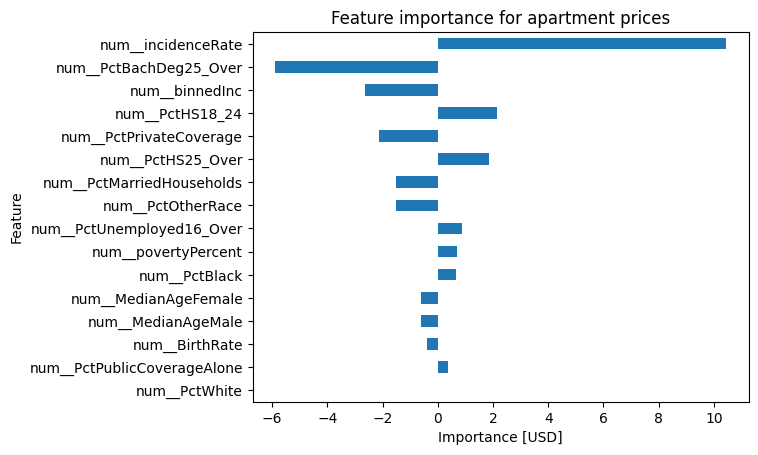

In [66]:
# Plot the feature importances
feature_importances_cap.sort_values(key=abs).tail(16).plot(kind='barh')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature importance for Cancer death rate");

This model goes further and claims that race has something to do with cancer.

it also claims tha median age fo males and females is also a determining factor

Observation. The model does not choose any of the location features as an important factor.
The location features were one hot encoded. Seems that your location is not important as much as what is happening in your location

This makes sense.Adequate healtcare should override location
If you get the proper treatments then you should recover from cancer no matter where you are located

In [69]:
# Test the model on the test set
test_pred = lasso_pipe_cap.predict(X_test)

In [71]:
# Test error
error_metrics(y_test, test_pred)

mae: 15.277591827778762
rmse: 20.417939128997915
R2 score 20.417939128997915


In [72]:
#Train error
error_metrics(y_train, y_train_cap_pred)

mae: 14.519165815268657
rmse: 19.498831109058216
R2 score 19.498831109058216


The model is robust and there is no overfitting going on, the errors are close